In [1]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.nn.modules.batchnorm import BatchNorm1d
import torch.nn.functional as F

In [2]:
! pip install wldhx.yadisk-direct
! curl -L $(yadisk-direct https://disk.yandex.com/d/eS6LL7bLmrlO7w) -o dogs.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  218M  100  218M    0     0  13.3M      0  0:00:16  0:00:16 --:--:-- 16.8M


In [3]:
! unzip -qq dogs.zip

In [4]:
resnet_transforms = transforms.Compose([
        transforms.Resize(256), # размер каждой картинки будет приведен к 256*256
        transforms.CenterCrop(224), # у картинки будет вырезан центральный кусок размера 224*224
        transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
        transforms.ToTensor(), # картинка из питоновского массива переводится в формат torch.Tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # значения пикселей картинки нормализуются
    ])

In [5]:
train_data = datasets.ImageFolder('./dogs/train', transform=resnet_transforms)
val_data = datasets.ImageFolder('./dogs/valid', transform=resnet_transforms)
test_data = datasets.ImageFolder('./dogs/test', transform=resnet_transforms)

In [6]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

In [8]:
import torchvision
from torchvision import datasets, models, transforms

model = models.resnet18(pretrained=True)

In [9]:
# Последний слой преобученной нейросети ResNET-18:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [11]:
model.fc = nn.Linear(512, 70)
model.fc

Linear(in_features=512, out_features=70, bias=True)

In [15]:
# Заморозка сверточных слоев преобученной нейросети ResNET-18:
for i, layer in enumerate(model.children()):
  if i < 9:
    for param in layer.parameters():
      param.requires_grad = False

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [17]:
from sklearn.metrics import accuracy_score


def evaluate(model, dataloader, criterion):
  y_pred_list = []
  y_true_list = []
  losses = []
  for i, batch in enumerate(dataloader):
    X_batch, y_batch = batch

    with torch.no_grad():

      y_pred = model(X_batch.to(device))

      loss = criterion(y_pred, y_batch.to(device))
      loss = loss.item()
      losses.append(loss)

      y_pred = torch.argmax(y_pred, dim=1)

    y_pred_list.extend(y_pred.cpu().numpy())
    y_true_list.extend(y_batch.numpy())
  acc = accuracy_score(y_pred_list, y_true_list)
  return acc, np.mean(losses)

In [18]:
def train(model, criterion, optimizer, n_epoch):
  data = {
      'acc_train' : [],
      'loss_train' : [],
      'acc_val' : [],
      'loss_val' : []
  }
  for epoch in tqdm(range(n_epoch)):
    for i, batch in enumerate(train_loader):
      X_batch, y_batch = batch
      y_pred = model(X_batch.to(device))
      loss = criterion(y_pred, y_batch.to(device))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    acc_train, loss_train = evaluate(model, train_loader, criterion)
    acc_val, loss_val = evaluate(model, val_loader, criterion)

    data['acc_train'].append(acc_train)
    data['loss_train'].append(loss_train)
    data['acc_val'].append(acc_val)
    data['loss_val'].append(loss_val)
  return model, data

In [19]:
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [21]:
model, data = train(model, criterion, optimizer, n_epoch=3)

  0%|          | 0/3 [00:00<?, ?it/s]

In [25]:
test_accuracy, _ = evaluate(model, test_loader, criterion)
test_accuracy

0.63

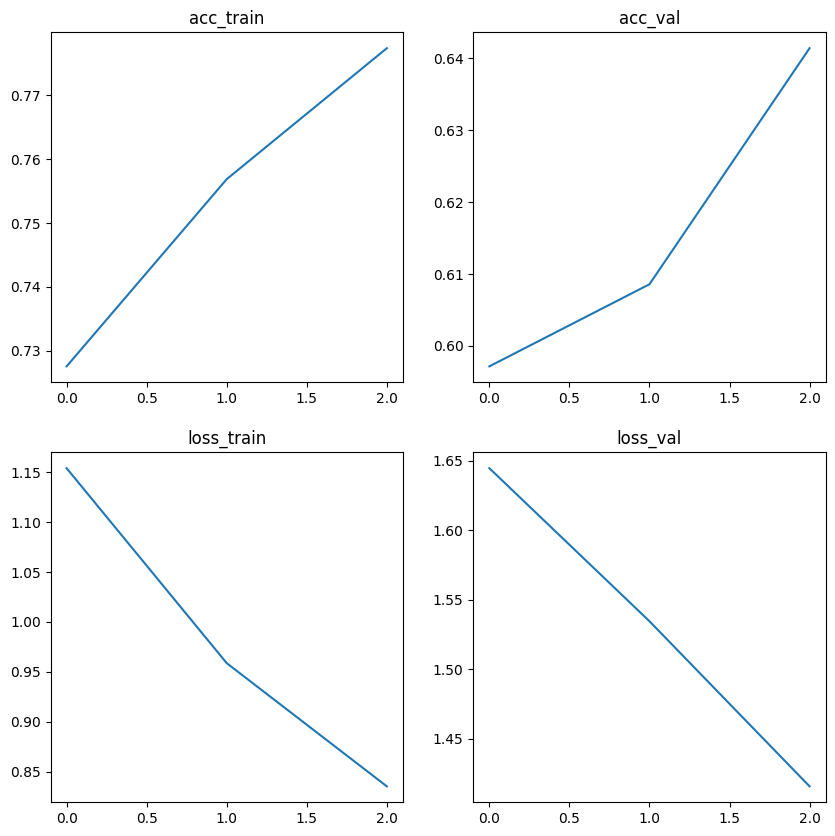

In [24]:
_, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

ox = list(range(3))

axes[0][0].plot(ox, data['acc_train'])
axes[0][0].title.set_text('acc_train')

axes[0][1].plot(ox, data['acc_val'])
axes[0][1].title.set_text('acc_val')

axes[1][0].plot(ox, data['loss_train'])
axes[1][0].title.set_text('loss_train')

axes[1][1].plot(ox, data['loss_val'])
axes[1][1].title.set_text('loss_val')

plt.show()